Found 10000 validated image filenames belonging to 2 classes.
Found 800 validated image filenames belonging to 2 classes.
Found 992 validated image filenames belonging to 2 classes.


'   \nÖnemli not : train, validation ve test verilerinde sadece yüz olan resimler üzerinde öğrenme modeli oluşturulduğu için\nbizim çekipte modele maskeli? yada maskesiz mi? diye sorduğumuz resim için genellikle maskesiz yanıtı alınmıştır.\nSebebide modeli sadece yüzleri kullanarak tanıttık fakat bizim çektiğimiz resimlerde yüzden başka çevremizdeki ortamda bulunmaktadır.\nBundan dolayı bizde sistemin doğru çalışması adına yüzü tespit edip (kırpıp) onu modele sorduk ve doğal olarak sonuçlar iyileşti.\nAyrıca yüz tespitinde kullanılan algoritmanın da başarıyı etkileyen faktörlerin başında gelmektedir, \nyüzü ne kadar iyi bulursa modelimiz daha iyi sınıflandırma yapabilmektedir.\nEğittiğimiz modeli kendi resimlerimiz üzerindeki sonuçlarına bakıcak olursak başarılı oldu diyebiliriz.\n'

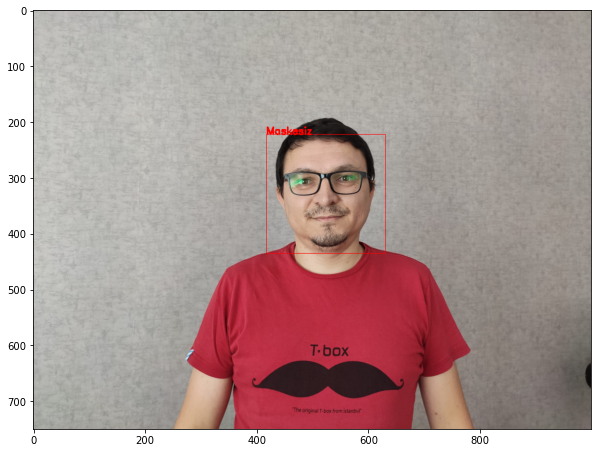

In [10]:
import pandas as pd
import numpy as np
import os
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
import cv2
from scipy.spatial import distance
from keras import layers
from keras import models
from keras import optimizers
from keras.applications.vgg19 import VGG19
from keras.applications.vgg19 import preprocess_input
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import load_model

#Verileri indexliyoruz
#Train klasörlerü altındaki maskeli ve maskesiz olarak ayrılmış resimlerin yerini ve etiket(sınıf) değerini tutan bir tablo oluşturuyoruz.
maskeliDizinTrain="veriSeti/Train/WithMask/"
maskesizDizinTrain="veriSeti/Train/WithoutMask/"

maskeliResimTrain = []
maskeliEtiketTrain = []
for i in os.listdir(maskeliDizinTrain):
    resim = os.path.join(maskeliDizinTrain , i)
    maskeliResimTrain.append(resim)
    maskeliEtiketTrain.append("maskeli")

maskesizResimTrain = []
maskesizEtiketTrain = []
for i in os.listdir(maskesizDizinTrain):
    resim = os.path.join(maskesizDizinTrain , i)
    maskesizResimTrain.append(resim)
    maskesizEtiketTrain.append("maskesiz")

maskeliTrain = pd.DataFrame()
maskeliTrain["resim"] = maskeliResimTrain
maskeliTrain["etiket"] = maskeliEtiketTrain

maskesizTrain = pd.DataFrame()
maskesizTrain["resim"] = maskesizResimTrain
maskesizTrain["etiket"] = maskesizEtiketTrain

trainingData = pd.concat([maskeliTrain, maskesizTrain], axis = 0, ignore_index = True)
trainingData=shuffle(trainingData)
#print(trainingData)

#Validation klasörlerü altındaki maskeli ve maskesiz olarak ayrılmış resimlerin yerini ve etiket(sınıf) değerini tutan bir tablo oluşturuyoruz.
#Buradaki resimleri modelimizi eğittikten sonra öğrenmenin doğruluğunu ölçmek için kullanıyoruz.
maskeliDizinValidation="veriSeti/Validation/WithMask/"
maskesizDizinValidation="veriSeti/Validation/WithoutMask/"

maskeliResimValidation = []
maskeliEtiketValidation = []
for i in os.listdir(maskeliDizinValidation):
    resim = os.path.join(maskeliDizinValidation , i)
    maskeliResimValidation.append(resim)
    maskeliEtiketValidation.append("maskeli")

maskesizResimValidation = []
maskesizEtiketValidation = []
for i in os.listdir(maskesizDizinValidation):
    resim = os.path.join(maskesizDizinValidation , i)
    maskesizResimValidation.append(resim)
    maskesizEtiketValidation.append("maskesiz")

maskeliValidation = pd.DataFrame()
maskeliValidation["resim"] = maskeliResimValidation
maskeliValidation["etiket"] = maskeliEtiketValidation

maskesizValidation = pd.DataFrame()
maskesizValidation["resim"] = maskesizResimValidation
maskesizValidation["etiket"] = maskesizEtiketValidation

validationData = pd.concat([maskeliValidation, maskesizValidation], axis = 0, ignore_index = True)
validatioData=shuffle(validationData)
#print(validatioData)

#Test klasörlerü altındaki maskeli ve maskesiz olarak ayrılmış resimlerin yerini ve etiket(sınıf) değerini tutan bir tablo oluşturuyoruz.
#Burdaki verileri de öğrenme işlemi gerçekleşmiş ve model oluştuktan sonra modelin doğruluğunu ve loss fonksiyonunu görmek için kullanıyoruz.
maskeliDizinTest="veriSeti/Test/WithMask/"
maskesizDizinTest="veriSeti/Test/WithoutMask/"

maskeliResimTest = []
maskeliEtiketTest = []
for i in os.listdir(maskeliDizinTest):
    resim = os.path.join(maskeliDizinTest , i)
    maskeliResimTest.append(resim)
    maskeliEtiketTest.append("maskeli")

maskesizResimTest = []
maskesizEtiketTest = []
for i in os.listdir(maskesizDizinTest):
    resim = os.path.join(maskesizDizinTest , i)
    maskesizResimTest.append(resim)
    maskesizEtiketTest.append("maskesiz")

maskeliTest = pd.DataFrame()
maskeliTest["resim"] = maskeliResimTest
maskeliTest["etiket"] = maskeliEtiketTest

maskesizTest = pd.DataFrame()
maskesizTest["resim"] = maskesizResimTest
maskesizTest["etiket"] = maskesizEtiketTest

testData = pd.concat([maskeliTest, maskesizTest], axis = 0, ignore_index = True)
testData=shuffle(testData)
#print(validatioData)

#Veriyi öğrenme sırasında gerçek zamanlı olarak yığınlar halinde döngüye alma işlemi için kullanılan komutlar.
#batch veri gruplarını büyüklüğünü ifade eder.
#fill_mode : Girdi sınırları dışında verilen noktaları doldurma yöntemidir.Yani eksik verileri tamamlamak için kullanılır.
#class_mode : Sınıf değerlerine göre sınıflama 
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                                   fill_mode = "nearest")

trainGen = train_datagen.flow_from_dataframe(dataframe = trainingData,
                                                    x_col = "resim",
                                                    y_col = "etiket",
                                                    target_size = (128, 128),
                                                    batch_size = 16,
                                                    class_mode = "binary")


#Öğrenme işleminden sonra öğrenmeyi doğrulamak için gerçek zamanlı olarak yığınlar halinde döngüye alma işlemi için kullanılan komutlar.
#Oluşturulan modele uygun doğrulama için gerekli verii belirli kalıplara sokarak sıralı şekkilde döngüye alır.
valid_datagen = ImageDataGenerator(rescale = 1./255,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                                   fill_mode = "nearest")

validGen = valid_datagen.flow_from_dataframe(dataframe = validationData,
                                                    x_col = "resim",
                                                    y_col = "etiket",
                                                    target_size = (128, 128),
                                                    batch_size = 16,
                                                    class_mode = "binary")
#Model oluşturulduktan sonra, modeli test etmek için test verilerinin yığınlar halinde döngüye alma işlemi için kullanılan jeneratör. Veri besleyici de denebilir.
#Modele uygun test verisini belirli kalıplara sokar
test_datagen = ImageDataGenerator(rescale = 1./255,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                                   fill_mode = "nearest")

testGen = test_datagen.flow_from_dataframe(dataframe = testData,
                                                    x_col = "resim",
                                                    y_col = "etiket",
                                                    target_size = (128, 128),
                                                    batch_size = 16,
                                                    class_mode = "binary")
"""
#model öğretme
#Modelin seçimi, öğrenme işlemi için ağırlığın belirlenmesi veri girişlerinin nasıl olacağı belirlenir.
vgg19 = VGG19(weights='imagenet',include_top=False,input_shape=(128,128,3))

#Katmanların özellikleri belirlenir.
#Her katman tek başına öğrenilebilirilik özelliğini açıyoruz
for layer in vgg19.layers:
    layer.trainable = True
#Kurduğumuz modelde herbir katman için bir giriş çok boyutlu veri(tensör) ve bir çıkış tensörüne sahip olduğumuz için 
#sequential(sıralı modeli) kullanıyoruz.  
#Dense:Oluşturulan katmanların aktivasyon fonksiyonunun belirlenmesinde vb. özellikler bütünüdür.
model = models.Sequential()
model.add(vgg19)
model.add(layers.Flatten())
model.add(layers.Dense(1,activation='sigmoid'))
#model.summary()

#compile : oluşturduğumuz modeli derlemek için kullanılır.
model.compile(loss = "binary_crossentropy",optimizer = optimizers.RMSprop(lr = 1e-4),metrics = ["accuracy"])

#Modelin eğitimi sırasında belirli değerlere ulaşılması durumunda öğrenme işlemini durdurmak için gerekli ayarların yapıldığı yerdir.
#Örneğin biz loss değerinin en düşük olduğu durumda modelizi kaydetmek istediğimizde aşağıdaki tanımlamaları yaptık.
#loss değeri bir önceki loss değerinden küçükse kaydetme işlemini gerçekleştiriyor.
#ve 50 epoch(devir) gerçekleşmiş ve kayıt işlemi gerçekleşmemiş ise öğrenme işlemini durduruyor.
early_stopping = EarlyStopping(patience = 50, monitor='loss',
                                 mode='min', restore_best_weights=True, 
                                 verbose = 1)

model_checkpoints = ModelCheckpoint("maskeliMaskesizResimOgrenmesi.h5", 
                                    save_best_only=True, verbose = 1)


callbacks = [model_checkpoints, early_stopping]

#Öğrenme işlemini çalıştırılır.
#Öğrenme işlemine öğrenme veri seti ve doğrulama veri seti tanımlanır.
#Artı olarak öğrenme sırasında otomatik kaydetme ve erken durdurma özellikleri tanımlanır.
model.fit(trainGen,steps_per_epoch=len(trainGen)//32,epochs=150,validation_data=validGen,validation_steps=len(validGen)//32, callbacks = callbacks)

"""

#En iyi duruma göre kayıt edilmiş öğrenme modeli bellekten yüklenir.
model = load_model("maskeliMaskesizResimOgrenmesi.h5")
"""
#Test verisinin kayıp fonsiyonunu öğrenelir.
testKayip, testDogruluk = model.evaluate(testGen, verbose=1)
print("Kayıp Fonkiyonu (Loss Function) : ", round(testKayip, 5))
"""
#yüz tespiti için haar kalıbını kullandık.
face_model = cv2.CascadeClassifier('haar/haarcascade_frontalface_default.xml')
#işleme tabi tutulacak resim bellekten yüklenir.
resim = cv2.imread('veriSeti/deneme/maskesiz7.jpeg')

#cep telefonu ile çekilen resimlerin boyutu büyük olduğu için yarı yarıya küçülttük.
height, width, channels = resim.shape
if(height>width):
    resim=cv2.resize(resim,(width//2,height//2))
else:
    resim=cv2.resize(resim,(width//2,height//2))

resim = cv2.cvtColor(resim, cv2.IMREAD_GRAYSCALE)

#resim üzerindeki yüzler haar'a göre tespit edildi.
yuzler = face_model.detectMultiScale(resim,scaleFactor=1.1, minNeighbors=4)

#Öğrenme modeline verilen resimden, model 0-1 aralığında bir değer döndürmektedir, 
#buna göre maskeli maskesiz mi olduğu anlaşılmaktadır.
maskEtiket = {0:'Maskeli',1:'Maskesiz'}
renk = {0:(0,255,0),1:(255,0,0)}

enAzAralik = 0

#Resim üzernde yüz varmı yokmu karar yapısı
if len(yuzler)>=1:
    #daha önce bulunan yüz ile aynı konumda mı diye kontrol edilir.
    etiket = [0 for i in range(len(yuzler))]
    for i in range(len(yuzler)-1):
        for j in range(i+1, len(yuzler)):
            aralik = distance.euclidean(yuzler[i][:2],yuzler[j][:2])
            if aralik<enAzAralik:
                etiket[i] = 1
                etiket[j] = 1
    #resim eski renkli haline geri döndürülür
    yeniResim = cv2.cvtColor(resim, cv2.COLOR_RGB2BGR)
    #tespit edilen yüz üzerinde mdele göre maskeli mi? maskesiz mi? kontrolü yağılır.
    #Eğer döndürülen değer 0.5'ten büyük ise maskesiz olduğu anlaşılır 0'a yakınsa maskelidir.
    #maskeli ise yüz yeşil çerçeve içine alınarak maskeli diye yazılır.
    #maskesiz ise yüz kırmızı çerçeve içine alınarak maskesiz diye yazılır.
    for i in range(len(yuzler)):
        (x,y,w,h) = yuzler[i]
        kesilmis = yeniResim[y:y+h,x:x+w]
        kesilmis = cv2.resize(kesilmis,(128,128))
        kesilmis = np.reshape(kesilmis,[1,128,128,3])/255.0
        sonuc = model.predict(kesilmis)
        cv2.putText(yeniResim,maskEtiket[round(sonuc[0][0])],(x, y), cv2.FONT_HERSHEY_SIMPLEX,0.6,renk[round(sonuc[0][0])],2)
        cv2.rectangle(yeniResim,(x,y),(x+w,y+h),renk[round(sonuc[0][0])],1)
    plt.figure(figsize=(10,10))
    plt.imshow(yeniResim)
            
else:
    #haar yüz tespit sistemi ile yüz tespit edilemez ise çıktı olarak resim üzerinde yüz bulunamadı uyarısı döndürülür.
    print("Resim üzerinde yüz tespit edilemedi.")
"""   
Önemli not : train, validation ve test verilerinde sadece yüz olan resimler üzerinde öğrenme modeli oluşturulduğu için
bizim çekipte modele maskeli? yada maskesiz mi? diye sorduğumuz resim için genellikle maskesiz yanıtı alınmıştır.
Sebebide modeli sadece yüzleri kullanarak tanıttık fakat bizim çektiğimiz resimlerde yüzden başka çevremizdeki ortamda bulunmaktadır.
Bundan dolayı bizde sistemin doğru çalışması adına yüzü tespit edip (kırpıp) onu modele sorduk ve doğal olarak sonuçlar iyileşti.
Ayrıca yüz tespitinde kullanılan algoritmanın da başarıyı etkileyen faktörlerin başında gelmektedir, 
yüzü ne kadar iyi bulursa modelimiz daha iyi sınıflandırma yapabilmektedir.
Eğittiğimiz modeli kendi resimlerimiz üzerindeki sonuçlarına bakıcak olursak başarılı oldu diyebiliriz.
"""